13443
61
95 13095 60 193
Verdadeiro negativo
3  -  Não recomenda
13444
61
95 13096 60 193
Verdadeiro negativo
0  -  Não recomenda
13445
61
95 13097 60 193
Verdadeiro negativo
2  -  Não recomenda
13446
61
95 13098 60 193
Verdadeiro negativo
4  -  Não recomenda
13447
61
95 13099 60 193
Verdadeiro negativo
1  -  Não recomenda
13448
61
95 13100 60 193
Verdadeiro negativo
0  -  Não recomenda
13449
61
95 13101 60 193
Verdadeiro negativo
1  -  Não recomenda
13450
61
95 13102 60 193
Verdadeiro negativo
0  -  Não recomenda
13451
61
95 13103 60 193
Verdadeiro negativo
0  -  Não recomenda
13452
61
95 13104 60 193
Verdadeiro negativo
3  -  Não recomenda
13453
61
95 13105 60 193
Verdadeiro negativo
0  -  Não recomenda
13454
61
95 13106 60 193
Verdadeiro negativo
0  -  Não recomenda
13455
61
95 13107 60 193
Verdadeiro negativo
1  -  Não recomenda
13456
61
95 13108 60 193
Verdadeiro negativo
3  -  Não recomenda
13457
61
95 13109 60 193
Verdadeiro negativo
0  -  Não recomenda
13458
61
95 13110 60 193


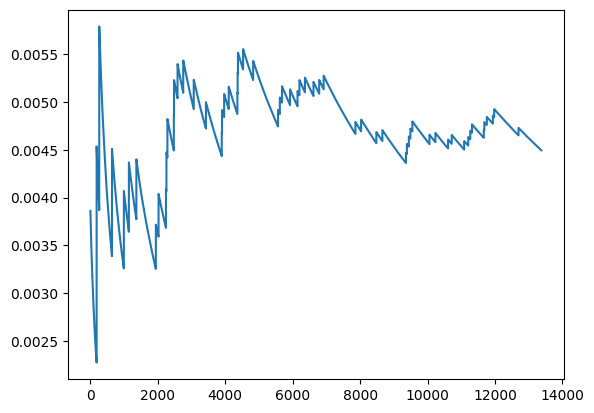

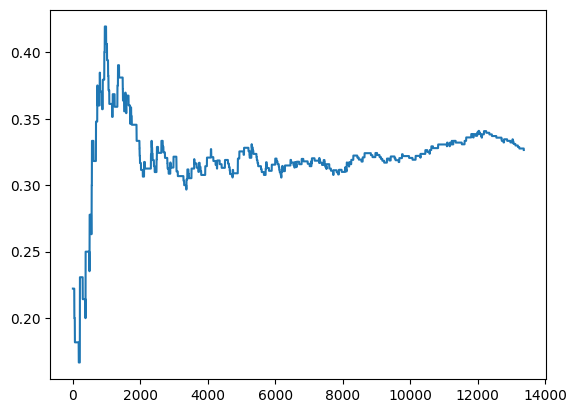

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import numpy as np
import random as rn
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt


# 1. Coleta de Dados (substitua com seus próprios dados)
# Suponha que você tenha um DataFrame 'df' com colunas: 'movie_id', 'user_id', 'rating', 'genre', etc.
df = pd.read_csv('/work/dataset/movies_metadata.csv')
# 2. Pré-processamento de Dados (se necessário)
# Separando dados de teste e treinamento
indices = pd.Series(df.index, index=df['overview']).drop_duplicates()
train_df, test_df = train_test_split(indices, test_size=0.3)
train_df = sorted(train_df)
test_df = sorted(test_df)

#Criando as classes de filmes que o usuário gosta e não gosta
n = 1000 #1000 filmes pertencem a classe de gosto do usuário
tfidf = TfidfVectorizer(stop_words='english')
df['overview'] = df['overview'].fillna('') #Remove espaços vazios
matrix_title = tfidf.fit_transform(df['overview']) #Vetoriza overview
cos_metter = linear_kernel(matrix_title, matrix_title[998]) #Faz distância de cossenos de um filme qualquer com todos os outros
#Escolhe os 1000 filmes mais próximos
ss = list(enumerate(cos_metter[0:(len(indices)-1)]))
ss = sorted(ss,key=lambda x: x[1], reverse=True)
ss = ss[0:n]
ss = sorted(ss)
m_ind = [i[0] for i in ss]
for a in range(len(m_ind)):
    m_ind[a] = indices[m_ind[a]]
print(df['title'].iloc[m_ind])

#Mapeando quais filmes de cada classe estão no grupo de treino
#Filmes do gosto do usuário
like_films = []
tt_n = 0
for j in train_df:
    for i in m_ind:
        if(j == i):
            like_films.append(j)
            tt_n = tt_n + 1

like_films = sorted(like_films)

#Filmes fora do gosto do usuário
deslike_films = []
cnt = 0
for i in train_df:
    if(i == like_films[cnt]):
        if(cnt < tt_n-1):
            cnt = cnt + 1
    else:
        deslike_films.append(i)


# Calcula vetores de texto
df['overview'] = df['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df['overview'])
tfidf_matrix_tr = tfidf_matrix[train_df]
tfidf_matrix_tr_like = tfidf_matrix[like_films]
tfidf_matrix_tst = tfidf_matrix[test_df]
tfidf_matrix_tr_deslike = tfidf_matrix[deslike_films]

#Para cada filme dos dados de treino mede a distância entre eles e os classifica

metr = []
for i in range(3):
    itr = 0
    k = 20*(i+1)+1 #Escolhe Ks 21, 41, 61
    true_positives = 0
    false_negatives = 0
    true_negatives = 0
    false_positives = 0

    for train in tfidf_matrix_tr: #Faz comparação de vizinhos próximos
        opt = 1
        fst = 0
        while(opt): #Implementa otimização
            if(fst):
                opt = 0
            if(not fst):
                tfidf_matrix_tr_aux = tfidf_matrix[sorted(like_films + deslike_films[0:2500])]
            else:
                tfidf_matrix_tr_aux = tfidf_matrix[sorted(like_films + deslike_films)]
            fst = 1
            cosine_sim = linear_kernel(tfidf_matrix_tr_aux, train)
            sim_scores = list(enumerate(cosine_sim[0:(len(train_df)-1)]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[0:k]
            movie_indices = [i[0] for i in sim_scores]
            for a in range(len(movie_indices)):
                movie_indices[a] = train_df[movie_indices[a]]

            #Descobre qual é a classe do filme atual           
            grupo = 0
            for index in like_films:
                if(index == train_df[itr]):
                    grupo = 1

            itr = itr + 1
            #Conta a quantidade de vizinhos próximos da classe do gosto do usuário
            cnt = 0
            for films in like_films:
                for ind in movie_indices:
                    if(ind == films):
                        cnt = cnt + 1
        
            estado = ""
            if(cnt > (k*n/len(train_df)+2)): #Pondera sobre a recomandação do filme
                if(opt):
                    print("Mais amostras, estado indefinido")
                    itr = itr - 1
                else:
                    estado = "Recomenda"
                    if(grupo):
                        print("Verdadeiro positivo")
                        true_positives = true_positives + 1
                    else:
                        print("Falso positivo")
                        false_positives = false_positives + 1
            else:
                opt = 0
                estado = "Não recomenda"
                if(grupo):
                    print("Falso negativo")
                    false_negatives = false_negatives + 1
                else:
                    print("Verdadeiro negativo")
                    true_negatives = true_negatives + 1
        print(cnt, " - ", estado)
        print(itr)
        print(k)
        print(true_positives, true_negatives, false_positives, false_negatives)
    metr.append([true_positives, true_negatives, false_positives, false_negatives])

#Compara qual k foi o melhor com base em F1    
ack = []
for b in metr:
    pr = b[0]/(b[0] + b[2])
    rc = b[0]/(b[0] + b[3])
    ack.append(2*rc*pr/(rc + pr))
g_ack = 0
g_ind = 0
for b in range(len(ack)):
    if(ack[b] > g_ack):
        g_ack = ack[b]
        g_ind = b

#Fase de teste

#Mapeia filmes do gosto do usuário no grupo de teste
like_films_tst = []
tt_n = 0
for j in test_df:
    for i in m_ind:
        if(j == i):
            like_films_tst.append(j)
            tt_n = tt_n + 1

like_films_tst = sorted(like_films_tst)

#Mapeia filmes fora do gosto do usuário no grupo de teste
deslike_films_tst = []
cnt = 0
for i in test_df:
    if(i == like_films_tst[cnt]):
        if(cnt < tt_n-1):
            cnt = cnt + 1
    else:
        deslike_films_tst.append(i)

#Para o k escolhido faz a classificação
itr = 0
true_positives = 0
false_negatives = 0
true_negatives = 0
false_positives = 0
TPR_vet = []
FPR_vet = []
k = 20*(g_ind + 1) + 1
for test in tfidf_matrix_tst:
    opt = 1
    fst = 0
    while(opt):
        if(fst):
            opt = 0
        if(not fst):
            tfidf_matrix_aux = tfidf_matrix[sorted(like_films + deslike_films[0:2500])]
        else:
            tfidf_matrix_aux = tfidf_matrix[sorted(like_films + deslike_films)]
        fst = 1
        cosine_sim_tst = linear_kernel(tfidf_matrix_aux, test)
        sim_scores_tst = list(enumerate(cosine_sim_tst[0:(len(train_df)-1)]))
        sim_scores_tst = sorted(sim_scores_tst, key=lambda x: x[1], reverse=True)
        sim_scores_tst = sim_scores_tst[0:k]
        movie_indices_tst = [i[0] for i in sim_scores_tst]
        for a in range(len(movie_indices_tst)):
            movie_indices_tst[a] = train_df[movie_indices_tst[a]]
        
        grupo = 0
        for index in like_films_tst:
            if(index == test_df[itr]):
                grupo = 1

        itr = itr + 1
        cnt = 0
        for films in like_films:
            for ind in movie_indices_tst:
                if(ind == films):
                    cnt = cnt + 1
        
        estado = ""
        if(cnt > (k*n/(len(test_df) + 1))):
            if(opt):
                print("Mais amostras, estado indefinido")
                itr = itr - 1
            else:
                estado = "Recomenda"
                if(grupo):
                    print("Verdadeiro positivo")
                    true_positives = true_positives + 1
                else:
                    print("Falso positivo")
                    false_positives = false_positives + 1
        else:
            opt = 0
            estado = "Não recomenda"
            if(grupo):
                print("Falso negativo")
                false_negatives = false_negatives + 1
            else:
                print("Verdadeiro negativo")
                true_negatives = true_negatives + 1
    print(cnt, " - ", estado)
    print(itr)
    print(k)
    print(true_positives, true_negatives, false_positives, false_negatives)
    if(true_positives and true_negatives and false_positives and false_negatives): #Registra TPR e FPR durante a classificação
        TPR = true_positives/(false_negatives + true_positives)
        TPR_vet.append(TPR)
        FPR = false_positives/(true_negatives + false_positives)
        FPR_vet.append(FPR)

#Calcula e escreve métricas    
Ac = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
Recall = true_positives/(true_positives + false_negatives)
precision = true_positives/(true_positives + false_positives)
print("Ac = ", Ac)
print("Recall = ", Recall)
print("Precision =", precision)
print("F1 = ", 2*precision*Recall/(precision + Recall))
print(metr)
print(ack)

#Plota TPR e FPR
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.plot(FPR_vet)
ax2.plot(TPR_vet)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b9a2a253-63c1-4a02-9767-e204bf387a02' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>